# The object slots model

In [47]:
import patches
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import plotnine as gg

In [2]:
help(patches.datasets.object_slots_model)

Help on function object_slots_model in module patches.datasets.pilgrimm.simple_models:

object_slots_model(width=10, shapes=None, occlusion_ranges=0, occlusion_probs=0.1, appearance_probs=0.01, magic=False, samples=0, random_state=None, seed=None)



In [149]:
osm = patches.datasets.object_slots_model(width=1, shapes=[np.array([[1]]), np.array([[1]])], magic=[False, True], samples=5000)

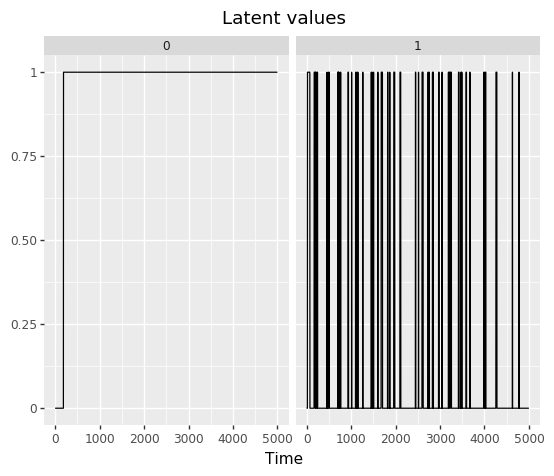

<ggplot: (8782769497871)>

In [150]:
osm.latent_evolution()

In [151]:
def model_generator(input_features, latent_features, timesteps, intermediate_features, **kwargs):
    encoder = nn.Linear(input_features, latent_features)
    predictor = nn.Linear(latent_features, timesteps*latent_features)
    decoder = nn.Linear(latent_features, input_features)
    return {
        'encoder': encoder,
        'predictor': predictor,
        'decoder': decoder
    }

In [152]:
patchclamp = patches.patchclamp.PatchClamp(model_generator)

In [204]:
cts = [patches.data.ContrastiveTimeseries(
    patches.datasets.object_slots_model(width=1, shapes=[np.array([[1]]), np.array([[1]])], magic=[False, True], samples=1000)\
                    .flat_array()\
                    .reshape(1, 1000, 2), contrast_size=9, drop_last=True) for __ in range(20)]

In [205]:
cac = patches.networks.ContrastiveAutoCoder(encoder=nn.Identity(),
                                            accumulator=nn.Linear(4, 2, bias=False),
                                            predictor=nn.Linear(2, 5*2, bias=False))

In [206]:
criterion = patches.losses.ContrastiveLoss(patches.losses.BilinearLoss())

In [207]:
loss_traj = []
angle = []
recurrent = []
optimizer = optim.Adam(cac.parameters(), lr=0.01)

In [208]:
n_epochs = 200

In [209]:
with tqdm(total=n_epochs*len(cts)*len(cts[0])) as pbar:
    for epoch in range(n_epochs):
        for ts in cts:
            code = torch.zeros(10, 2)
            running_loss = 0
            for i in range(len(ts)):
                data = ts[i]
                optimizer.zero_grad()
                model_output, code = cac(data, code)
                loss = criterion(**model_output)
                loss.backward(retain_graph=True)
                optimizer.step()
                running_loss += loss
                pbar.update(1)
                if i%20 == 19:
                    loss_traj.append(running_loss.detach().numpy()/20)
                    theta = next(cac.parameters()).detach().numpy()
                    angle.append(theta.sum()/(np.sqrt((theta**2).sum())*10))
                    recurrent.append(list(cac.parameters())[1].detach().numpy())
                    running_loss = 0

100%|██████████| 380000/380000 [16:06<00:00, 393.12it/s]


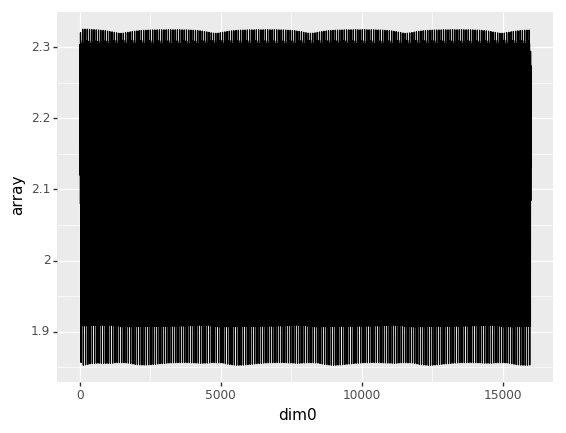

<ggplot: (-9223363254085202393)>

In [210]:
(gg.ggplot(patches.utils.array_to_dataframe(np.array(loss_traj)), gg.aes(x='dim0', y='array')) +
    gg.geom_line())

In [211]:
list(cac.parameters())

[Parameter containing:
 tensor([[ 0.2079, -0.2174,  1.0466, -2.4464],
         [-0.0448, -0.1184, -0.4516, -2.4077]], requires_grad=True),
 Parameter containing:
 tensor([[ 0.9889, -0.4210],
         [-3.4283, -2.3938],
         [ 0.9481, -0.3765],
         [-2.4695, -2.1053],
         [ 0.9239, -0.4612],
         [-1.9370, -1.9792],
         [ 0.9075, -0.5584],
         [-1.5746, -1.8847],
         [ 0.8561, -0.5456],
         [-1.3285, -1.7934]], requires_grad=True)]

In [141]:
input = np.array([
    [0., 0.],
    [0., 0.],
    [1., 0.],
    [1., 0.],
    [1., 1.],
    [1., 1.],
    [0., 1.],
    [1., 1.],
    [0., 0.]
]).reshape(-1, 1, 1, 2)

In [142]:
input.shape

(9, 1, 1, 2)

In [143]:
probe = torch.zeros(1, 2)

In [144]:
code = np.empty(shape=(0, 2), dtype=np.float32)

In [145]:
cac.encoder(inp)

tensor([[[ 0.9328, -0.4094]]], grad_fn=<UnsafeViewBackward>)

In [146]:
for inp in torch.from_numpy(input.astype(np.float32)):
    state = cac.encoder(inp)
    probe = cac.accumulator(torch.cat((probe, state[:, 0]), dim=-1))
    code = np.append(code, probe.detach().numpy(), axis=0)

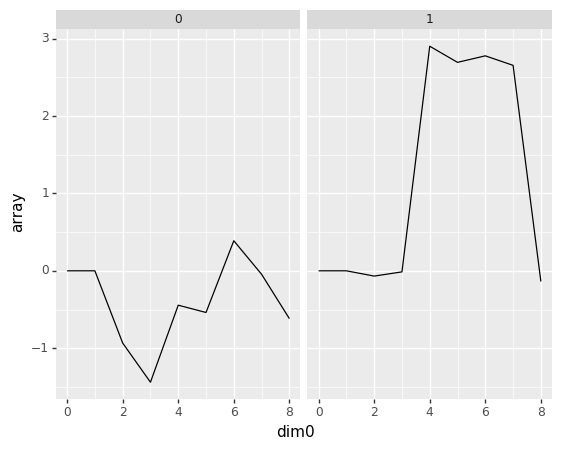

<ggplot: (8782769455666)>

In [147]:
(gg.ggplot(patches.utils.array_to_dataframe(code), gg.aes(x='dim0', y='array')) +
 gg.geom_line() +
 gg.facet_wrap('dim1'))

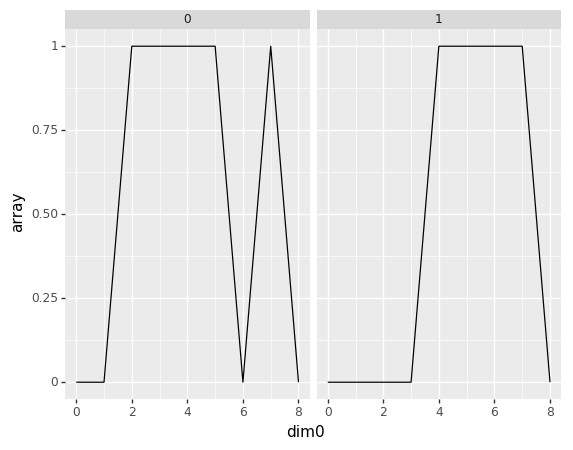

<ggplot: (8782769333610)>

In [148]:
(gg.ggplot(patches.utils.array_to_dataframe(input), gg.aes(x='dim0', y='array')) +
 gg.geom_line() +
 gg.facet_wrap('dim3'))